### Decoding filter

In [1]:
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from palettable.scientific.sequential import Nuuk_3 as ColMap
from src.config import SUBJECTS, SESSION, N_LAYER
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"
FILTER_SIZE = [0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0]
FILTER_FREQ = [0.9296334326946054, 1.4150774765146426, 1.7875717924913979, 2.101599027058178, 3.0724871146982524, 3.817475746651763, 4.445530215785323, 4.998857310906818, 7.169829073414797, 10.240046783482603]

# set
SESS = "VASO"
PART = 2  # 0, 1, or 2

In [2]:
def get_profile(sess, day, filter):
    y = np.zeros((N_LAYER, len(SUBJECTS)))
    for i, subj in enumerate(SUBJECTS):
        path = Path(DIR_DATA) / subj / f"{sess}{SESSION[subj][sess][day]}"
        file = path / f"bandpass_{filter}" / "accuracy.csv"
        data = np.genfromtxt(file, delimiter=',')
        for j in range(N_LAYER):
            y[j, i] = np.mean(data[j, :] * 100)
    return y

def regrid_data(data, nx=100, ny=100):
    # grid of input array
    x_old = np.linspace(0, 1, N_LAYER)
    y_old = FILTER_FREQ
    xgrid_old, ygrid_old = np.meshgrid(x_old, y_old)
    xi_old = np.stack((xgrid_old.flatten(), ygrid_old.flatten()), 1)

    # grid of output array
    x_new = np.linspace(0, 1, nx)
    y_new = np.linspace(0.95, 10.0, ny)
    xgrid_new, ygrid_new = np.meshgrid(x_new, y_new)
    xi_new = np.stack((xgrid_new.flatten(), ygrid_new.flatten()), 1)

    # grid values from old grid to new grid
    data_new = griddata(xi_old, data.flatten(), xi_new, method='cubic')

    x_new = np.reshape(xi_new[:, 0], (ny, nx))
    y_new = np.reshape(xi_new[:, 1], (ny, nx))
    data_new = np.reshape(data_new, (ny, nx))

    x_new = x_new - np.min(x_new)
    x_new = x_new / np.max(x_new) * nx

    y_new = y_new - np.min(y_new)
    y_new = y_new / np.max(y_new) * ny

    return x_new, y_new, data_new

In [3]:
data = np.zeros((len(FILTER_SIZE), N_LAYER))
for i, f in enumerate(FILTER_SIZE):
    y1 = get_profile(SESS, 0, f)
    y2 = get_profile(SESS, 1, f)
    y3 = np.append(y1, y2, axis=1)
    if PART == 0:
        data[i, :] = np.mean(y1, axis=1)
    elif PART == 1:
        data[i, :] = np.mean(y2, axis=1)
    elif PART == 2:
        data[i, :] = np.mean(y3, axis=1)
    else:
        raise ValueError("Unknown part!")

nx, ny = 50, 100
x, y, data = regrid_data(data, nx=nx, ny=ny)
#data = gaussian_filter(data, 10.0)

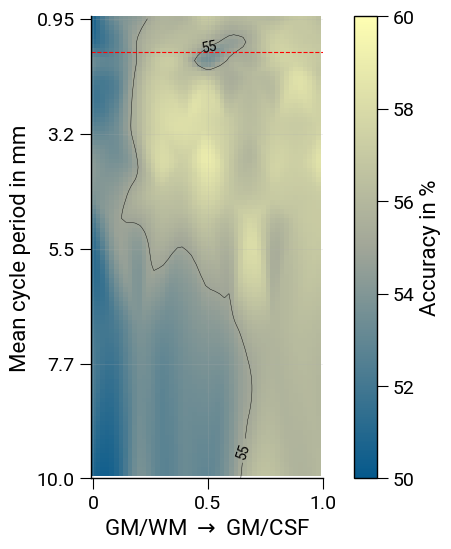

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(data, cmap=ColMap.mpl_colormap)
if SESS == "VASO":
    im.set_clim([50, 60])
    cs = ax.contour(x, y, data, [55.0], colors="black", linewidths=0.3)  # ge_epi
elif SESS == "GE_EPI":
    im.set_clim([75, 100])
    cs = ax.contour(x, y, data, [88.0], colors="black", linewidths=0.3)  # ge_epi
elif SESS == "SE_EPI":
    cs = ax.contour(x, y, data, [70.0], colors="black", linewidths=0.3)  # se_epi
ax.clabel(cs, inline=True, fontsize=10)
ax.set_xticks([0, nx/2, nx], [0,0.5,1.0])
ax.set_yticks([0, ny/4, ny/2, 3*ny/4, ny], [0.95, 3.2, 5.5, 7.7, 10.0])
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("Mean cycle period in mm")
ax.axhline(7.2, color="red", linestyle="--", linewidth=0.8)
cbar = plt.colorbar(im)
cbar.set_label("Accuracy in %")
file_out = f"/data/pt_01880/decoding_filter_{SESS}_{PART}.svg"
fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")